In [ ]:
import os

import pandas as pd
import numpy as np
import pickle as pkl

import matplotlib as mpl
import matplotlib.pyplot as plt

dataset_path = os.environ.get('RCMD_DATASET_PATH', '../dataset')
print('Dataset path', dataset_path)
log_path = os.environ.get('RCMD_LOG_PATH', '../logs')
print('Log path', log_path)

In [ ]:
# MovieLens 100K를 데이터셋을 불러옵니다.
df_ratings = pd.read_csv(os.path.join(dataset_path, 'ratings_100k.csv'))
df_ratings['date'] = df_ratings.pop('timestamp').pipe(lambda x: pd.to_datetime(x, unit='s'))
df_user = pd.read_csv(os.path.join(dataset_path, 'users_100k.csv'), index_col='user id')
df_movie = pd.read_csv(os.path.join(dataset_path, 'movies_100k.csv'), index_col='movie id')

display(df_ratings.head())
display(df_user.head())
display(df_movie.head())

In [ ]:
from sklearn.model_selection import train_test_split
# 학습:평가 = 8:2로 하여 학습/평가를 셋을 합니다.
df_train, df_test = train_test_split(df_ratings, train_size=0.8, random_state=123)

# gender, occupation을 활용하기 위해 df_user와 결합합니다.
# genre를 활용하기 위해 df_movie와 결합합니다.
df_train_2 = df_train.join(df_user, on='user id').join(df_movie, on='item id')
df_test_2 = df_test.join(df_user, on='user id').join(df_movie, on='item id')
df_train_2.head()

# 인공신경망(Artificial Neural Network)

- 신경세포를 본 딴 모수적 모델

> 선형 회귀 모델이 나타내지 못하는 패턴(Non-Linear 패턴)을 나타낼 수 있습니다.
>
> 층(Layer): 입력을 처리하여 변환하는 연속된 연산 단위 
>
> 은닉층 (Hidden Layer): 기본적으로 가중치와 활성화 구성

  유닛(Unit) - 은닉층의 노드수: 은닉층의 출력 변수의 수
 
  가중치(Weight) - 모수(Parameter)에 해당
  
  > 밀도레이어(Dense Layer):  $N_{input} × N_{output}$ 인 행렬 \[+ $ N_{output}$ 인 벡터\]
  
 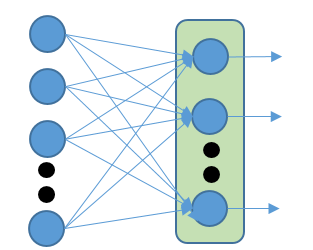
  
  활성화 함수(Activation Function)
  
  > 신경세포의 역치를 나타냄 - 신경세포에 전달된 자극이 다음 신경세포로 전달 되려면 일정 수준이상의 자극이 필요
  >
  > 수학적으로는 비선형성을 부여
  >
  > Ex) sigmoid / tanh / relu / leaky relu / ... 
  
  
- 학습 알고리즘: 경사하강법

[Tensorflow Playground](https://playground.tensorflow.org/)

#### 예제: MovieLens100K 데이터셋에서 추천에 활용할 수 있는 모델을 만들어 봅니다.

Task: 추천시 Ranking에 활용할 수 있도록 사용자별 영화 평점을 예측기를 만들어 봅시다. 

- 지표: R2

- 학습데이터:평가데이터 = 8:2

- 검증법: 5-fold cross validation

**인공신경망**모델을 이용한 초간단 모델을 만들어 봅니다.

- 첫번째 은닉층의 크기는 16, 두번째 은닉층의 크기는 8로 설정합니다.

- 입력변수: 사용자의 rating 평균, 영화의 rating 평균, 사용자의 직업, 성별과 영화 장르 정보를 입력 변수

**다층신경망 모델**

sklearn.neural_network.MLPRegressor

In [ ]:
# 모델 검증 프로세스부터 구현합니다.
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import r2_score

# 5-fold cross validate splitter를 설정합니다. random_state=123, shuffle=True
cv = KFold(n_splits=5, random_state=123, shuffle=True)
def eval_model(model, df, X):
    # cross_validate를 활용하여 R2 Score를 지표로하고 Splitter는 5-fold cross validate, train_score까지 반환토록하여 model 성능을 측정합니다.
    # scoring = 'r2', 
    return cross_validate(
        model, df[X], df['rating'], scoring = 'r2', cv = cv, return_train_score = True
    )

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

X_genre = df_movie.columns[2:].tolist()
ct = ColumnTransformer([
    ('tge', TargetEncoder(target_type='continuous'), ['user id', 'item id']),
    ('ohe', OneHotEncoder(drop='first'), ['occupation', 'gender']),
    ('pt', 'passthrough', X_genre)
])

reg_mlp = make_pipeline(
    ct, 
    MLPRegressor(
        hidden_layer_sizes=[16, 8], activation='relu', 
        learning_rate_init=0.001, alpha=0.001, random_state=123
    )
)
X_mlp = ['user id', 'item id', 'occupation', 'gender'] + X_genre
result = eval_model(reg_mlp, df_train_2, X_mlp)
result, np.mean(result['test_score']) # 0.2756

In [ ]:
from sklearn.metrics import r2_score

reg_mlp.fit(df_train_2[X_mlp], df_train_2['rating'])
r2_score(
    df_test_2['rating'], reg_mlp.predict(df_test_2[X_mlp])
) # 0.2771

### 전통적 방법의 한계와 극복 방안


#### 한계점

- 데이터의 복잡도가 커질 수록 범주별 가변수를 만들어 표현하는 원-핫 인코딩 방법은 비효율은 커집니다.

- 평균과 같은 통계 기반의 방법은 사용자와 아이템과 같이 높은 복잡도를 지닌 요소를 보다 정확하게 나타내기 위해서는 점점 더 복잡한 처리 과정이 요구 됩니다.

#### 극복 방안

- 인공 신경망의 임베딩 레이어를 통한 사용자와 아이템의 특성의 표현
> 사용자와 아이템을 저차원 벡터로 나타낼 수 있어 인코딩 효율화
>
> 특성 추출을 위한 별도 엔지니어링 없이 신경망의 학습과 추론 의해 특성을 추출


#### 전제 조건

- 많은 수의 데이터
> 데이터가 부족한 상황에서는 효과성 미비

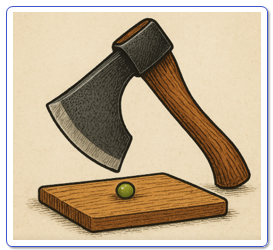

### 임베딩(Embedding)

문장, 이미지, 음성, 고차원의 범주 등 복잡도가 높은 형태의 데이터를 **저**차원의 연속형 변수로 나타낸 데이터

Ex) 영화 요약 OpenAI의 임베딩

#### 임베딩 레이어

범주형 데이터를 연속적인 실수 벡터 공간으로 매핑
- 구성 및 연산
- 입력(m): 범주형 데이터 에서 범 주의 정수 인덱스 (Ex: 사과→1, 배 →2, …, Unknown →0)
- 임베딩 크기(n): 범주를 표현할 벡터의 크기
- 범주 수(k): 범주형 데이터에서 범주의 개수
- 출력: m×n

- 파라미터 구성
> 임베 딩 테이블(k × n): 각 범주값의 의미를 나타내는 벡터의 집합
> 
> 연산: 입력이 나타내는 위치의 벡터 반환


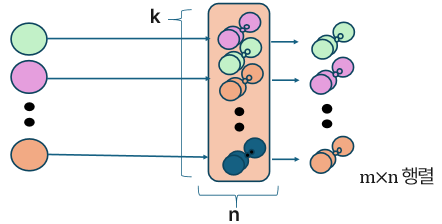

#### 임베딩 레이어의 특징

- 의미적 관계 학습: 역전파에 의해 데이터에 나타난 범주의 특징 기록
> 추상적인 개념이나 관계를 수치적으로 표현
- 희소성 문제 해결
> 높은 가짓수를 가진 범주형 변수의 가변수 처리에 의한 고차원 희소벡터의 비효율 해결
> 
> 일반화 능력 향상 및 과적합 방지

- 활용
> 단어, 사용자 ID, 상품 등 비교적 높은 가짓수를 가진 범주형 데이터 표현
- 문제점
> 새로 등장한 범주나 등장 빈도가 적은 범주에 대해서는 낮은 성능
> 
> 최적의 임베딩 크기 결정 필요

#### 추천에서의 임베딩

사용자, 아이템과 같이 고차원 범주를 인코딩하기 위해 사용합니다.

여기서, user id와 item id를 대상 변수의 비율/평균으로 인코딩하는 것이 아닌, 임베딩으로 인코딩을 해봅니다. 

이 임베딩은 학습을 통해 데이터에 내재된 특징이 수치화 됩니다.


이를 위해 Tensorflow를 사용해보겠습니다.

**Tensorflow**로 모델을 구성해 나가는 것을 해봅니다.


위에서 생성한 **df_train_2**, **df_test_2** 데이터셋으로 진행합니다.

**Neural Networks Architecture**

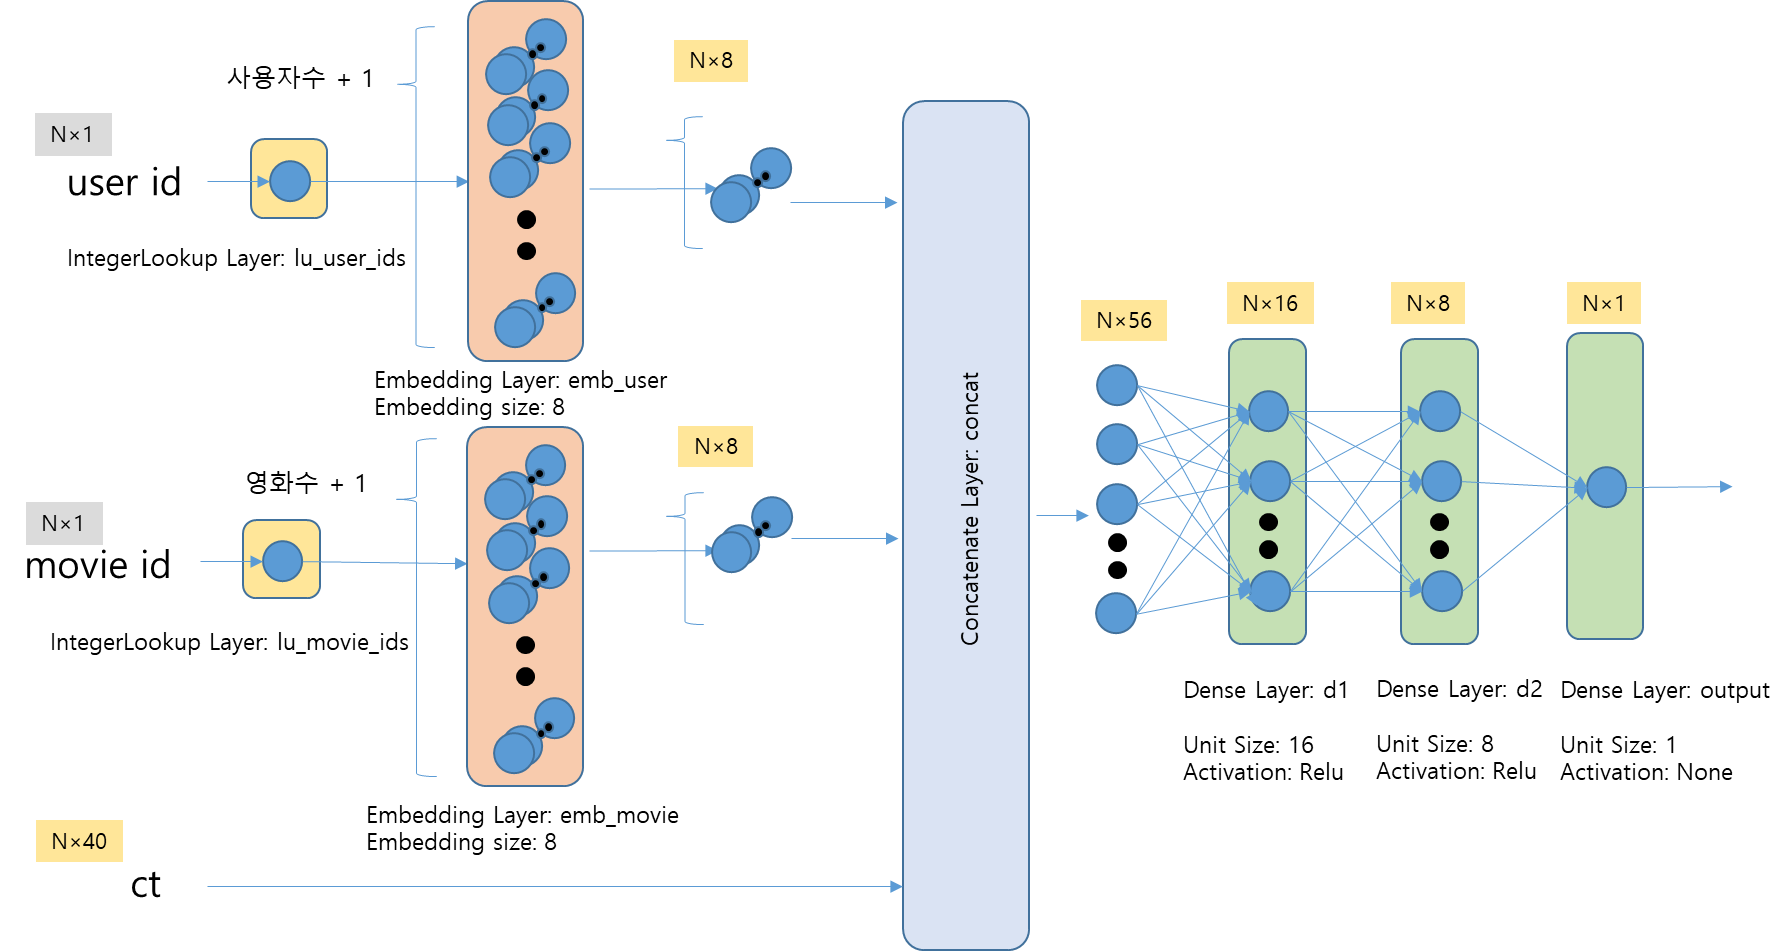

**N**: 배치 사이즈(batch size)

**ct**: 사용자 직업, 성별 가변수와 영화의 장르 여부 데이터

In [ ]:
df_train_2.head()

user id와 item id는 모두 정수형 인덱스 입니다.

Embedding Layer와 IntegerLookup Layer를 이용하여 user id와 item id를 임베딩으로 나타내는 네트워크를 디자인해 보겠습니다.

**Embedding Layer: tf.keras.layers.Embedding**

Tensorflow에서 제공하는 Embedding Layer

(범주의 개수) × (임베딩 벡터 크기)의 **학습이 가능한 Tensor**를 지니고 있으며

0-기반 위치 인덱스를 사용합니다.

In [ ]:
import tensorflow as tf

In [ ]:
# 범주의 수가 4개 이고, 벡터 크기가 2인 임베딩 레이어를 만들어 봅니다.
emb_test = #TODO-with
# 0, 1, 2, 3, 1 위치에 해당하는 임베딩을 emb_test에서 가져옵니다.
emb_test(#TODO-with)

**Integer Lookup Layer: tf.keras.layers.IntegerLookup**

범주형 변수의 수준이 정수형 ID로 되어있을 때, 정수형 ID를 0-기반 위치 인덱스 변환 할 때 사용합니다.

범주형 변수가 포함한 수준들을 vocabulary라고 합니다.

vocabulary에 없는 수준이 입력되면 기본적으로 0을 반환합니다.

In [ ]:
# IntegerLookup의 기능을 확인합니다.
# vocabulary가 [100, 200, 300] 일때,

lookup_test = #TODO-with
# 입력값이 [100, 300, 1, 200] 의 위치 정보를 확인해 봅니다.
#TODO-with

**IntegerLookup Layer + Embedding Layer**

사전에 없는 범주(Out-of Vocabulary) 까지 포함하여 임베딩 사이즈를 (범주수 + 1) x (임베딩 사이즈)로 설정합니다.

In [ ]:
# vocabulary가 [100, 200, 300]인 정수이고,
# 범주의 숫자가 3이고 임베딩 벡터의 수가 2개 인 임베딩 층을 만듭니다.

lookup_test = #TODO-with

emb_test = #TODO-with

# 1차원 입력 변수[100, 300, 1, 300, 1000]의 임베딩 벡터를 출력해봅니다.
x = tf.constant([100, 300, 1, 300, 1000])
print(x)
x = #TODO-with
print(x)
x = #TODO-with
print(x)
emb_test.get_weights()

**네트워크 일부분만 가져오겠습니다. 아래 네트워크만 우선 구현해 봅니다.**

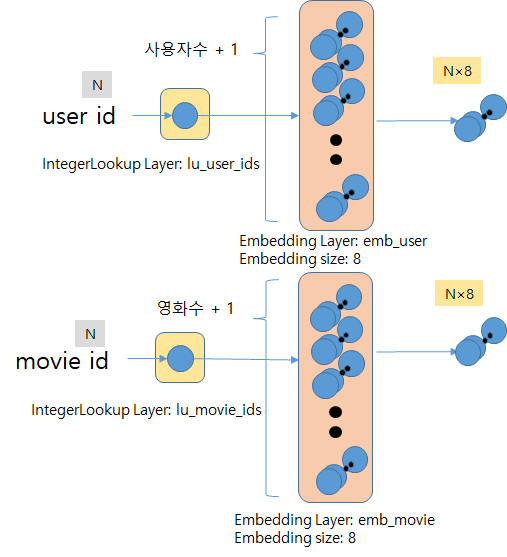

In [ ]:
# user id를 vocabulary로 하여 user id를 위치 index로 바꾸는 IntegerLookup Layer를 만듭니다.
lu_userid = #TODO-with
# user id 에 대한 Embedding Layer를 만듭니다. OOV 사이즈 1을 고려합니다.
# 임베딩의 크기는 8로 합니다.
emb_user = #TODO-with
# df_train_2에서 처음 5행의 user id 를 Tensorflow Tensor로 만듭니다.
x = tf.constant(df_train_2['user id'].head())
print(x)
# user id → 위치 Index
x = #TODO-with
print(x)
# 위치 Index → 임베딩
x = #TODO-with
print(x)
x.shape

In [ ]:
# movie id를 vocabulary로 하여 movie id를 위치 index로 바꾸는 IntegerLookup Layer를 만듭니다.
lu_movieid = #TODO

# movie id에 대한 Embedding Layer를 만듭니다. OOV 사이즈 1을 고려합니다.
emb_movie = #TODO

# df_train_2에서 처음 5행의 item id 를 Tensorflow Tensor로 만듭니다.
x = tf.constant(df_train_2['item id'].head())
print(x)
# movie id → 위치 Index
x = #TODO
print(x)
# 위치 Index → 임베딩
x = #TODO
x

**Concatenate layer**

입력 받는 tensor 들을 결합하여 하나의 tensor로 만듭니다.

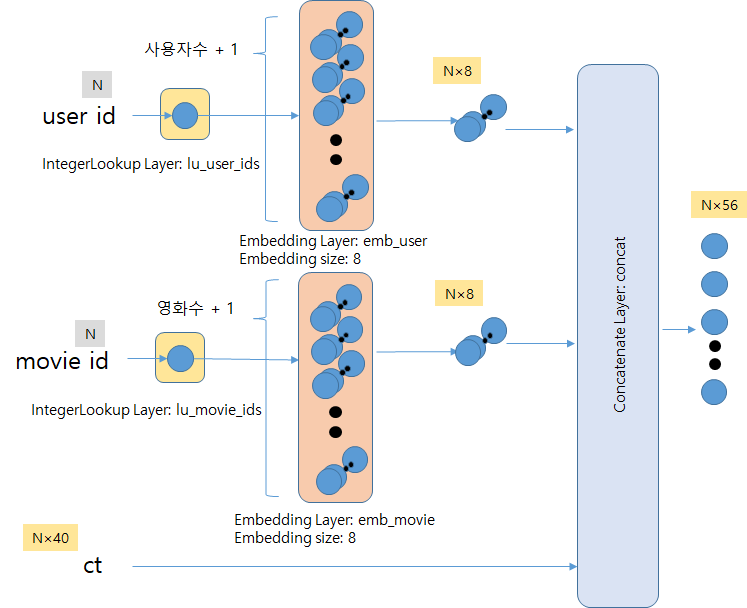

In [ ]:
# ct 값을 만들기 위한 ColumnTransformer를 만듭니다.
# Genre와 직업, 성별을 변환기를 설정합니다.
ct = ColumnTransformer([
    ('pt', 'passthrough', X_genre),
    ('ohe', OneHotEncoder(drop='first'), ['occupation', 'gender']),
])

ct_cols = X_genre + ['occupation', 'gender']
# 학습시킵니다.
ct.fit(df_train_2[ct_cols])
print("ct values size: {}".format(len(ct.get_feature_names_out())))

In [ ]:
# 처음 5줄에 대한 ct 변환값을 가져옵니다.
x_ct = ct.transform(df_train_2.head()[ct_cols])
x_ct, x_ct.shape

**Concatenate Layer**

tf.keras.layer.Concatenate(axis=결합의 기준이 되는 축(차원))

In [ ]:
df_ = df_train_2.head() # Layer의 테스트를 위해 df_train2 의 처음 2개의 데이터를 가져옵니다.
# df_ user id의 임베딩을 가져옵니다.
x_user = tf.constant(df_['user id'])
x_user = lu_userid(x_user)
x_user = emb_user(x_user)
print(x_user)

# 테스트를 위해 처음 부분의 item id를 가져옵니다.
x_movie = tf.constant(df_['item id'])
x_movie = lu_movieid(x_movie)
x_movie = emb_movie(x_movie)
print(x_movie)

# ColumnTransformer의 출력을 가져옵니다.
x_ct = tf.constant(ct.transform(df_[ct_cols]))

x_user.shape, x_movie.shape, x_ct.shape

In [ ]:
# axis = -1 마지막 차원끼리 결합을 시키는 layer를 만듭니다.
concat = #TODO-with

In [ ]:
# 3개의 입력값 x_user, x_movie, x_ct를 결합시킵니다.
print(x_user.shape, x_movie.shape, x_ct.shape)
x_concat = #TODO-with
x_concat.shape

**밀도레이어로 은닉층을 구성합니다.**


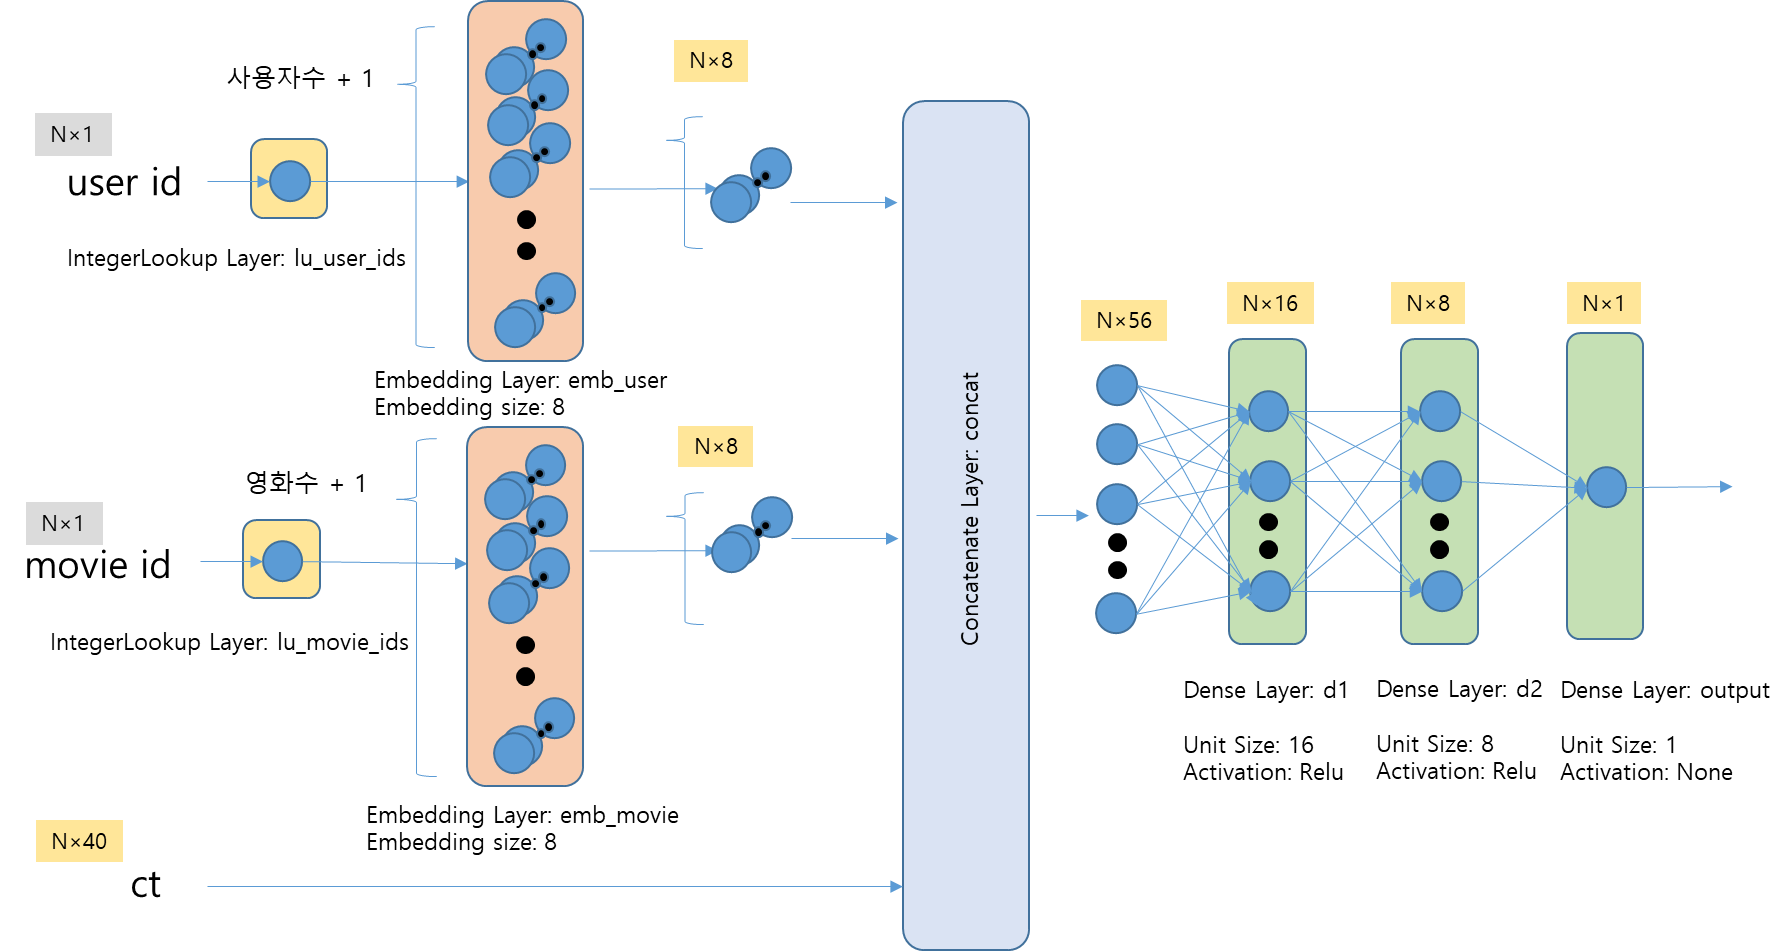

**밀도레이어**

입력과 출력이 weight와 곱으로 연결된 레이어

$O = W_{{n\_out}×{n\_in}} @ I + [Intercept_{n\_out}]$, 

@: 행렬곱, n_in: 입력 수, n_out: 출력 수

**tf.keras.layers.Dense(출력 수, activation=활성화 함수, kernel_initializer=weight 초기화 방법)**

activation: 'relu', 'sigmoid', 'tanh', ...

kernel_initialzier: 

보통은 glorot_uniform 

sigmoid, tanh와 같이 대칭 형태의 활성화 함수 - glorot_normal

relu와 같이 비대칭 - he_uniform

In [ ]:
# 첫번째 밀도 레이어를 생성합니다. relu에 효과가 좋은 초기화인 he_uniform을 설정합니다.
dense1 = #TODO-with

In [ ]:
# 두번째 밀도 레이어를 생성합니다. relu에 효과가 좋은 초기화인 he_uniform을 설정합니다.
dense2 = #TODO-with

In [ ]:
# glorot_uniform 방식으로 초기화 합니다.
o = #TODO-with

In [ ]:
# 3개의 입력값 x_user, x_movie, x_ct를 결합시킨 x_concat을 dense1 레이어에 전달합니다.
x_h = #TODO-with
print(x_h.shape)
# x_h를 dense2 레이어에 전달합니다.
x_h = #TODO-with
print(x_h.shape)
# x_h를 출력레이어에 전달합니다.
y_hat = #TODO-with
y_hat

In [ ]:
losses = tf.keras.losses.MeanSquaredError()
losses(df_train_2.head()['rating'], y_hat)

**Tensorflow model**

입력과 출력, 레이어 그리고 모델들로 구성된 Tensorflow 객체

모델 작성 방법(기본) 

모델의 클래스는 tf.keras.Model을 상속받습니다.

신경망이 고도화 될 수록 구조가 복잡해집니다. 복잡한 구조를 구현하기 위해서는 모듈화가 필수적입니다. 

마찬가지로 추천 시스템의 여러가지 요소들을 붙여 보다 정교한 모델을 만들어가기 위해서는 모듈화가 필요합니다. 

Tensorflow Model을 기반으로 구성 요소를 객체화하여 구현합니다.

생성자 작성: 여러가지 초기화 작업을 합니다.

    부모클래스의 생성자를 호출합니다.
    
    모델을 위한 초기화 루틴을 작성합니다.
    
    모델 레이어들의 instanace를 생성합니다.

call 메소드 작성: 모델 layer의 호출 플로우를 구현합니다. 

    입력 Tensor를 매개 변수로 정의합니다.
    
    training=False를 기본 매개 변수로 둡니다.
    
    정의한 레이어의 호출 플로우를 작성합니다.
    
    출력 텐서를 반환합니다.

In [ ]:
# 먼저 안정적인 수행을 위해 Tensorflow 데이터셋을 만듭니다.
ds = #TODO-with

In [ ]:
# 텐서플로우 데이터셋 일부를 출력해봅니다.
for X, y in ds.batch(32).take(1):
    print(X)
    print(y)

In [ ]:
class RatingModel(tf.keras.Model):
    def __init__(self, user_ids, movie_ids):
        """
        RatingModel 생성자입니다.
        Parameters:
            user_ids: array-like
                등장한 user_id 수준 리스트
            movie_ids: array-like
                등장한 movie_id 수준 리스트
        """
        super().__init__() # 부모 클래스의 생성자를 호출합니다.
        
        # user id들을 사전으로 구성하여 user id를 입력을 받아 이를 1부터 시작하는 인덱스로 변환해주는 Layer를 생성합니다.
        self.lu_user_ids = #TODO-with
        # movie id들을 사전으로 구성하여 user id를 입력을 받아 이를 1부터 시작하는 인덱스로 변환해주는 Layer를 생성합니다.
        self.lu_movie_ids = #TODO-with
        
        # 사용자 임베딩을 생성합니다. OOV를 포함하여 사용자수 + 1입니다.
        self.emb_user = #TODO-with
        # 영화 임베딩을 생성합니다. OOV를 포함하여 영화수 + 1입니다.
        self.emb_movie = #TODO-with
        
        # Concatenate Layer 생성합니다.
        self.concat = #TODO-with
        
        # Dense Layer 1 생성합니다. unit: 16, activation: relu,  initializer: he_uniform
        self.d1 = #TODO-with
        # Dense Layer 2 생성합니다. unit: 8, activation: relu, initializer: he_uniform
        self.d2 = #TODO-with
        # 출력 Layer를 생성합니다. initializer: glorot_uniform
        self.o = #TODO-with
    
    def call(self, x, training=False):
        """
        모델을 호출합니다.
        Parameters: 
            x: dict-like
                'user_id': shape이 N인 user_id 텐서
                'movie_id': shape이 N인 movie_id 텐서
                'ct': shape이 N×40인 ct 전처리기를 거친 변환된 텐서
        """
        x_user = #TODO-with # 사용자 ID에서 임베딩 인덱스로 변환합니다. x['user_id'] N 정수 / x_user: N 정수
        x_user = #TODO-with # x_user에 해당하는 임베딩을 반환합니다. x_user: N×8 정수
        x_movie = #TODO-with # 영화 ID에서 임베딩 인덱스로 변환합니다. x['movie_id'] N 정수 / x_movie: N 정수
        x_movie = #TODO-with # x_movie에 해당하는 임베딩을 반환합니다. x_movie: N×8 정수
        x = #TODO-with # x_user, x_movie, X['ct']을 결합합니다. X['ct']: N×40, x: N×56
        x = #TODO-with # Dense Layer 1 x: N×16
        x = #TODO-with # Dense Layer 2 x: N×8
        return #TODO-with # Output Layer x: N×1

In [ ]:
# 5-fold cross validation을 합니다.

valid_scores_ =  []
cv = KFold(5, random_state = 1, shuffle = True)
for train_idx, test_idx in cv.split(df_train_2):
    print('Fold #{}'.format(len(valid_scores_) + 1))
    tf.keras.backend.clear_session() # Tensorflow 세션을 초기화 합니다.
    reg_nn_rating = RatingModel(
        df_train_2['user id'].unique(), 
        df_train_2['item id'].value_counts().pipe(lambda x: x.loc[x >= 5].index.tolist()) # 평점이 5회 이상인 item 만 Embedding을 사용토록 합니다.
    ) 

    # 검증 학습셋 Dataset을 만듭니다. 
    # df_train_2로  user_id: user id, movie_id: item id ct:는 ct transform으로 하고 target은 rating인 Tensorflow DataSet을 만듭니다.
    # Shuffle 10000 → Batch 128 로 처리합니다. 
    # Shuffle은 데이터가 순서상 치우침이 있을 때, 이 치우침을 해소시켜 학습의 효율성을 높여줍니다.
    ds_train_2 = df_train_2.iloc[train_idx].pipe(
        lambda x: #TODO-with
    ).shuffle(10000).batch(128)

    # 검증셋 Dataset을 만듭니다. 
    # df_test_2로  user_id: user id, movie_id: item id ct:는 ct transform으로 하고 target은 rating인 Tensorflow DataSet을 만듭니다.
    # Batch 128 로 처리합니다.
    ds_valid_2 = df_train_2.iloc[test_idx].pipe(
        lambda x: #TODO-with
    ).batch(128) # 검증 테스트셋 Dataset을 만듭니다.
    
    # 모델 학습 설정을 합니다.
    reg_nn_rating.compile(
        optimizer= tf.keras.optimizers.Adam(), # Adam Optimizer를 사용합니다.
        loss= tf.keras.losses.MeanSquaredError()# 평균오차제곱합(Mean Squared Error)를 손실로 사용합니다.
    )
    # ds_train_2로 학습하고, ds_valid_2를 검증셋으로 설정합니다. 총 10회 train 셋에 대한 학습을 반복합니다.
    reg_nn_rating.fit(ds_train_2, validation_data = ds_valid_2, epochs = 10)
    # 검정 테스트셋 ds_valid_2의 의 r2_score를 측정합니다.
    valid_scores_.append(
        r2_score(
            df_train_2.iloc[test_idx]['rating'], reg_nn_rating.predict(ds_valid_2)
        )
    )
del ds_train_2, ds_valid_2
valid_scores_

In [ ]:
np.mean(valid_scores_) # LR: 0.275.. => MLP: 0.277

In [ ]:
# 전체 Train에 학습하고 Test로 평가합니다.
tf.keras.backend.clear_session()
reg_nn_rating = RatingModel(
    df_train_2['user id'].unique(), 
    df_train_2['item id'].value_counts().pipe(lambda x: x.loc[x >= 5].index.tolist())
)
reg_nn_rating.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.MeanSquaredError(),
)

ds_train_2 = tf.data.Dataset.from_tensor_slices(
            ({'user_id': df_train_2['user id'], 'movie_id': df_train_2['item id'], 'ct': ct.transform(df_train_2)},
              df_train_2['rating'])
        ).shuffle(10000).batch(128)

ds_test_2 = tf.data.Dataset.from_tensor_slices(
            ({'user_id': df_test_2['user id'], 'movie_id': df_test_2['item id'], 'ct': ct.transform(df_test_2)},
              df_test_2['rating'])
        ).batch(128)
reg_nn_rating.fit(ds_train_2, validation_data=ds_test_2, epochs=10)
r2_score(df_test_2['rating'], reg_nn_rating.predict(ds_test_2))

In [ ]:
reg_nn_rating.summary() # LR: 0.275.. MLP: 0.277

In [ ]:
# 추출한 내용을 Tensorflow Projector를 통해 확인해 봅니다.

import os
import tensorflow as tf
from tensorboard.plugins import projector
%load_ext tensorboard

In [ ]:
# 신경망을 통해 학습된 Movie Embedding을 시각화해봅니다.
log_dir=os.path.join(log_path, 'nn_basic')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in df_movie.loc[
            df_train_2['item id'].value_counts().pipe(lambda x: x.loc[x >= 5].index.tolist()),
            'movie title'
        ]:
        f.write("{}\n".format(i))

# 임베딩 내용중 OOV에 해당하는 첫번째 벡터를 제외하고 기록합니다.
weights = tf.Variable(reg_nn_rating.emb_movie.get_weights()[0][1:])
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))


config = projector.ProjectorConfig()
embedding = config.embeddings.add()

embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

저장한 내용을 텐서보드로 시각화해봅니다.

wsl 커맨드 창에서, notebook이 있는 경로로 이동하여 

아래 커맨드를 실행시켜 tensorboard 서버를 구동시킵니다.

```bash
tensorboard --logdir logs/nn_basic/ --bind_all
```

브라우져에서, http://localhost:6006 에 접근하면 

tensorboard 사이트에 접근하여, 우측 상단에 드롭 박스에 Projector를 선택하면, 

Embedding을 3차원 공간에 투영시킨 시각화 결과를 볼 수 있습니다.

## (비모수적 모델) Non-Parametric Model

**모수적 모델**: 모집단의 지식(패턴)을 고정된 함수 구조로 나타내는 모델

**비모수적 모델**: 모집단의 지식(패턴)을 고정되지 않은 함수 구조로 나타내는 모델

비모수적 모델은 데이터를 나타내는 함수 구조에 대한 가정이 없어

적용할 수 있는 데이터의 폭이 넓습니다.

### 결정 나무(Decision Tree)

 입력에 대한 판단 과정을 트리 구조로 나타낸 모델.
 
 결정나무는 데이터에 맞춰 트리를 성장시킵니다.
 
 ⇒ 트리가 지나치게 성장할 경우 과적합이 발생합니다.

 과적합에 대응하기 위한 트리의 성장을 제한 시키는 여러 규제 장치를 가지고 있습니다.

 ⇒ 정교한 튜닝이 필요합니다.
 
**모수적 모델에 비한 단점** 

- 학습 데이터셋 전체를 메모리에 올려야 하므로, 커다란 데이터로 학습시키려면 많은 연산 자원이 필요합니다.

- 데이터에  맞춰 함수 구조가 만들어지므로, 학습 데이터에서 보여진 유형에 대해서만 성능을 보장할 수 있습니다.

## 앙상블 모델

- 일반화 성능 향상을 위해 여러 모델을 결합한 모델 

### Boosting 

- 이전까지 결합된 모델의 손실(Loss)을 줄이는 모델을 결합해가는 앙상블 기법

### Bagging 

- 모델의 변동성을 줄이기 위해 Boostrapping을 통하여 다수의 모델을 만들어 변동성 줄이는 앙상블 기법

### LightGBM 으로 추천에 사용해 볼만한 모델을 만들어 봅시다. 


**LightGBM** : Microsoft Researcher를 중심으로 만든 Gradient Boosting Tree 모델입니다.

- 연속형 변수를 구간화하여 모델의 속도를 비약적으로 향상시킴과 동시에,

- 기본적인 설정으로도 상당한 성능을 얻을 수 있고, 튜닝을 통한 성능 향상을 기대할 수 있는 강력한 머신 러닝 모델입니다.

- Tabular 데이터(레코드는 행단위로 변수들은 열단위로 구성된 2차원 데이터)에 강력한 성능을 발휘합니다.

데이터셋을 만들어 봅니다.

- df_train셋에서 like 변수를 rating이 사용자의 rating 평균 이상이면 True 아니면 False로 정의하여 df_train_3 셋을 만듭니다.

- 사용자의 장르별 선호도를 구하기 위해 df_train_3에 df_movie와 결합합니다.

- 사용자가 장르별로 like를 보인 비율을 측정하고 이를 예측에 활용합니다.

- 사용자의 직업, 성별을 활용하기 위해 사용자 성별 정보도 결합합니다.

- 모수적 모델에 대한 연구가 핵심이므로,

- 검정에 시간을 투자하지 않고, 학습과 테스트만 해봅니다.

사용만 해보고 갑니다.

In [ ]:
# like를 만듭니다.
df_train_3 = df_train.assign(
    like = df_train.groupby('user id')['rating'].transform('mean') < df_train['rating']
)

# test는 train에서 측정한 사용자별 평균을 기준으로 like를 구합니다.
df_test_3 = df_test.assign(
    like = lambda x: x['user id'].map(df_train.groupby('user id')['rating'].mean()) < x['rating']
).dropna()

# Genre별 선호비율 조사하기위해 genre를 결합시킵니다.
# 추가적으로 사용자 정보도 결합시킵니다.
X_genre = df_movie.columns[2:].tolist()
df_train_3 = df_train_3.join(df_movie[X_genre], on='item id').join(df_user, on='user id')
df_test_3 = df_test_3.join(df_movie[X_genre], on='item id').join(df_user, on='user id')

In [ ]:
# df_train_3에서 사용자별 장르의 선호도 변수로 뽑아 봅니다.

# 영화별 여러 장르가 있으므로, 먼저 melt를 통해 user id별, genre, like 여부인 컬럼을 구성합니다.
# 피벗팅을 이용하여 사용자 장르별 like비율을 만듭니다.
# 결측치는 0으로 채웁니다.
df_user_genre = df_train_3[['user id', 'like']  + X_genre].melt(id_vars=['user id', 'like'], var_name='genre').pipe(
    lambda x: x.loc[x['value'] == 1, ['user id', 'like', 'genre']]
).pivot_table(
    index='user id', columns='genre', values='like', aggfunc='mean'
).fillna(0).rename(columns=lambda x: x + '_mean')
X_genre_mean = df_user_genre.columns.tolist()
df_user_genre.head(1)

In [ ]:
# df_train_3와 df_test_3에  df_user_genre를 결합시킵니다.

df_train_3 = df_train_3.join(df_user_genre, on='user id', how='inner')
df_test_3 = df_test_3.join(df_user_genre, on='user id', how = 'inner')
display(df_train_3.head())
display(df_test_3.head())

In [ ]:
import lightgbm as lgbm
from sklearn.preprocessing import TargetEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

X_genre = df_movie.columns[2:].tolist()
X_lgb = [i for i in df_train_3.columns if i not in['date', 'like', 'zip code', 'rating']]
ct = ColumnTransformer([
    ('tge', TargetEncoder(target_type='binary'), ['user id', 'item id']),
    ('ohe', OneHotEncoder(), ['gender', 'occupation']),
    ('pt', 'passthrough', [i for i in X_lgb if i not in ['gender', 'occupation', 'user id', 'item id']])
])
clf_lgb = make_pipeline(
    ct, 
    lgbm.LGBMClassifier(random_state=123, verbose=-1)
)
clf_lgb.fit(df_train_3[X_lgb], df_train_3['like'])

(
    roc_auc_score(df_train_3['like'], clf_lgb.predict_proba(df_train_3[X_lgb])[:, 1]),
    roc_auc_score(df_test_3['like'], clf_lgb.predict_proba(df_test_3[X_lgb])[:, 1]),
)

In [ ]:
import seaborn as sns
plt.figure(figsize = (8, 5))
sns.barplot( 
    data=pd.DataFrame({
        'name': clf_lgb[0].get_feature_names_out(),
        'importance': clf_lgb[1].feature_importances_
    }).sort_values('importance', ascending=False).iloc[:30],
    x='importance', y='name'
)
plt.tight_layout()
plt.show()

# 비지도 학습

- 군집화(Clustering ): 비슷한 속성을 지닌 데이터 포인트를 그룹화하는 과정

- 차원축소(Dimension Reduction): 정보의 손실을 최소화하여 데이터의 변수의 수를 줄이는 과정

**예제: 차원 축소 기법을 활용한 초간단 텍스트 마이닝**

영화 줄거리 데이터에서, Bag-of-words 모델 + TF-IDF 변환 + TruncatedSVD 모델을 이용한 텍스트 임베딩 추출

> Bag-of-words : 문서를 단어들의 출현 빈도로 나타냅니다.
>
> TF-IDF 변환: 단어 빈도수를 전체 문서들에서 두루 나오는 단어의 가중치를 낮추어 변환합니다.
>
> TruncatedSVD: 변수의 수를 줄입니다.

→ LSA(Latent Semantic Allocation) model

In [ ]:
with open(os.path.join(dataset_path, 'tmdb_movie_info_kr.pkl'), 'rb') as f:
    movie_info_kr = pkl.load(f)

In [ ]:
movie_info_kr[1]['overview']

한글 형태소 분석기: 어절에서 형태소 단위의 분리를 해주며, 이와 함께  형태소의 품사를 제공합니다.

[KIWI](https://github.com/bab2min/kiwipiepy)

In [ ]:
# 한글 형태소 분석기: 형태소 분석기를 통해 어절에서 단어를 추출합니다. 

from kiwipiepy import Kiwi
from tqdm import tqdm
kiwi = Kiwi()

In [ ]:
kiwi.analyze(movie_info_kr[1]['overview'])

단어 자체만으로 의미를 지닌다고 보기 힘든, 조사(tag가 J로 시작) 어미(tag가 E로 시작), 접미사(tag X로 시작), 문장부호(tag S로 시작) 주격보어(VCP) 하는 단어들은 불용어 처리합니다.

In [ ]:
words = [t.form for t in kiwi.tokenize(movie_info_kr[1]['overview']) if t.tag[0] not in ['J', 'E', 'X', 'S'] and t.tag != 'VCP']
words

In [ ]:
# Document(doc): 영화 한 편의 줄거리와 제목 
# 각각의 Documenst들에서 불용어를 제외한 단어를 추출합니다.
doc_ids = []
docs = []
for k, v in tqdm(movie_info_kr.items()):
    words = [t.form for t in kiwi.tokenize(v['title']) if t.tag[0] not in ['J', 'E', 'X', 'S'] and t.tag != 'VCP']
    words += [t.form for t in kiwi.tokenize(v['overview']) if t.tag[0] not in ['J', 'E', 'X', 'S'] and t.tag != 'VCP']
    doc_ids.append(k)
    docs.append(words)

In [ ]:
# 처음 두 개의 Document의 내용을 뽑아봅니다.
docs_str = [' '.join(i) for i in docs]
docs_str[:2]

In [ ]:
# CountVectorizer: Bag of Words Model의 sklearn version 입니다.
from sklearn.feature_extraction.text import CountVectorizer
# Document Frequency: 최소 3개의 문서에서 등장한 단어를 Vocabulary에 포함합니다.
cnt_vec = CountVectorizer(min_df=3)
cnt_vec.fit(docs_str)

In [ ]:
# Vocabulary에 23778(KIWI 형태소 분석기 버전에 따라 수치가 다를 수있습니다)개의 단어가 포함 됐습니다.
len(cnt_vec.vocabulary_)

In [ ]:
[docs_str[0]]

In [ ]:
# 첫번째 문장만의 변환값을 가져옵니다.
vec = cnt_vec.transform([docs_str[0]])[0]
# 단어 출현빈도를 출력해 봅니다.
for k, l in zip(vec.data, cnt_vec.get_feature_names_out()[vec.indices]):
    print(l, k)

TFIDF 변환을 통해 두루 나오는 단어의 가중치를 낮춰줍니다.

$tf(t, d)  = \frac{f_{t,d}}{\sum_{t'∈f_{f',d}}f_{t',d}}$

$idf(t, D) = \log{\frac{N}{|\{d∈D: t∈d\}|}}$

$tfidf(t, d, D) = tf(t,d)\cdot idf(t, D)$

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_tf = TfidfTransformer()

In [ ]:
tfidf_tf.fit(cnt_vec.transform(docs_str))

In [ ]:
vec = tfidf_tf.transform(cnt_vec.transform([docs_str[0]]))[0]
for k, l in zip(vec.data, cnt_vec.get_feature_names_out()[vec.indices]):
    print(l, k)

In [ ]:
vec, len(docs_str)

CountVectorizer → TFIDF 를 거쳐나온 문서 Matrix의 사이즈는 |D|×|V| , |D|: 문서수 |D|=86576, |V|: 단어수, |V| = 24698

TruncatedSVD를  이용하여, 문서 Matrix의 사이즈를 축소시킵니다.

TruncatedSVD는 PCA에서 변수들의 공분산 행렬을 구하는 과정에서, 중심평균화(평균을 0으로 만드는 처리과정)을 제외한 PCA 기법입니다.

단어 Vector는 굉장히 Sparse한 벡터이므로, 평균이 0에 가까운 것이 대부분이어서 중심평균화 생략의 영향은 크지 않습니다.

중심평균화를 하면 Sparse한 벡터가 0이 아닌 요소가 대부분의 값이 되기 때문에, 데이터의 사이즈가 굉장히 커지게 되고, 

많은 연산과 메모리를 요구하게 됩니다.

TruncatedSVD의 사용은 굉장히 Smart한 선택입니다.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

# LSA(Latent Semantic Allocation)
# CountVectorizer → TFIDF → TruncatedSVD
lsa = make_pipeline(
    CountVectorizer(min_df = 3), #  3개 이상의 문서가 나오는 단어를 사전에 포함시키는 Bag-of-Word 모델 변환기를 설정합니다.
    TfidfTransformer(), # TF-IDF 변환기를 설정합니다.
    TruncatedSVD(n_components = 128) # Truncated SVD 모델을 사용하여, 24698개에서 128개로 사이즈를 축소시킵니다.
)
lsa.fit(docs_str)

In [ ]:
lsa.transform(docs_str[:2]).shape

In [ ]:
# 전체의 변동성(정보) 중에서 128 차원의 데이터가 설명하는 변동성(정보)를 구합니다.
np.sum(lsa[2].explained_variance_ratio_)

In [ ]:
# 추출한 내용을 Tensorflow Projector를 통해 확인해 봅니다.

import os
import tensorflow as tf
from tensorboard.plugins import projector
%load_ext tensorboard

In [ ]:
# Tensorboard에 출력할 내용이 담긴 폴더를 설정합니다.
log_dir=os.path.join('logs', 'lsa')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Embedding과 출력될 Metadata를 기록합니다.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in doc_ids:
        f.write("{}\n".format(movie_info_kr[i]['title']))

# Embedding의 내용을 설정합니다.
weights = tf.Variable(lsa.transform(docs_str))
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# 설정에 따라 임베딩을 기록합니다.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
# 이 경우에는 wsl 커맨드 창을 통해  tensorboard를 구동한 방법은 
# 서버를 종료할 때에 서버 Process를 구동 시킨 wsl 창에서
# 서버를 직접 종료하면 되지만,(Ctrl + C)
# 아래 방법은 Notebook 창에서 tensorboard를 직접 구동시키는 방법인데요,
# wsl 환경에서는 서버가 정상적으로 종료 되지 않고 ghost processing가 되어 버려서
# wsl 환경에서 진행하신다면 아래 명령을 수행하는 것을 권장하지 않습니다.
# 이 경우에는 wsl 커맨드 창을 통해 구동하는 것을 권장합니다.

# %tensorboard --logdir logs/lsa/ --bind_all

In [ ]:
# tensorboard 서버 process 번호를 조회합니다.
# !ps -ef|grep tensorboard

In [ ]:
# tensorboard Process를 조회 후 Process를 종료시킵니다.
# !kill [tensorboard PID]

WSL 환경에서

- multi_rcmd 컨테이너에 진입한 콘솔이 있다면 재사용 가능합니다.
```
docker exec -it multi_rcmd /bin/bash
```
- tensorboard 서버를 구동시킵니다.
```
tensorboard --logdir /logs/lsa/ --host=0.0.0.0 --port=6006
```